In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

First of all I read all the files and merged them into one dataframe. I will use the alpha diversity, the relative abundance of species, the comunity state types which it is really informative, the phylotypes but just the ones with distances of 1e0 as it is the less complex (1845 columns), our data is highly multidimensional and we have not much samples, probably incresing the complexity of the samples will give us less than we obtain. We will also use the metadata and just few data about genus. I read about the preterm condition and how microbiome afect it, most important genus are Prevotella and Lactobacillus, and as we have the complete description of species in the dataframe, I just took these two from genuses, to give them more importance.

In [2]:
alpha=(
    pd.read_csv("training_data_2022-07-21/alpha_diversity/alpha_diversity.csv", 
                      index_col="specimen")
)
species=(
    pd.read_csv("training_data_2022-07-21/taxonomy/taxonomy_relabd.species.csv", 
                      index_col="specimen")
)
cst=(
    pd.read_csv("training_data_2022-07-21/community_state_types/cst_valencia.csv", 
                      index_col="specimen")
)
phylo=(
    pd.read_csv("training_data_2022-07-21/phylotypes/phylotype_relabd.1e0.csv", 
                      index_col="specimen")
)
genus=(
    pd.read_csv("training_data_2022-07-21/taxonomy/taxonomy_relabd.species.csv", 
                      index_col="specimen")
)
#important genus for preterm birth
genus_preterm=["Lactobacillus","Prevotella"]
genus=genus[genus_preterm]
metadata=(
    pd.read_csv("training_data_2022-07-21/metadata/metadata.csv", index_col="specimen", na_values="Unknown")
)

Now we merge the dataframes into one (complete_df)

In [3]:
phylo_metadata=pd.merge(phylo, metadata, left_index=True, right_index=True)
phylo_cst_metadata=pd.merge(cst, phylo_metadata, left_index=True, right_index=True)
phylo_alpha_cst_metadata=pd.merge(alpha, phylo_cst_metadata, left_index=True, right_index=True)
phylo_alpha_cst_species_metadata=(
    pd.merge(species, phylo_alpha_cst_metadata, left_index=True, right_index=True)
)
complete_df=(
    pd.merge(phylo_alpha_cst_species_metadata, genus, suffixes=(None, "_genus"), 
             left_index=True, right_index=True)
)

First of all we split train and test data, to prevent data leakage. As we can see, I will remove the variable "delivery_week" as it obviosly give direct information of the variable we are predicting. But I will also remove the variable "collect_week". Which it is trully informative, but in some cases the sample was taken after week 37, what supposed a data leackage as that would directly say that the sample is term.

In [4]:
from sklearn.model_selection import train_test_split
y=complete_df[["was_preterm", "was_early_preterm"]].astype("int")
y=pd.merge(y, complete_df["participant_id"], left_index=True, right_index=True)
complete_df.drop(["was_preterm", "was_term", "project", "participant_id", "delivery_wk", "was_early_preterm", "collect_wk"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(complete_df, y, test_size=0.33, random_state=1)

print(f' dataset train has {X_train.shape}')
print(f' dataset test has {X_test.shape}')


 dataset train has (2397, 3991)
 dataset test has (1181, 3991)


First we analyzed the distribution of the data, specially the variable used in prediction

% of preterm 0.2764114030184461
% of early preterm 0.10816098378982672


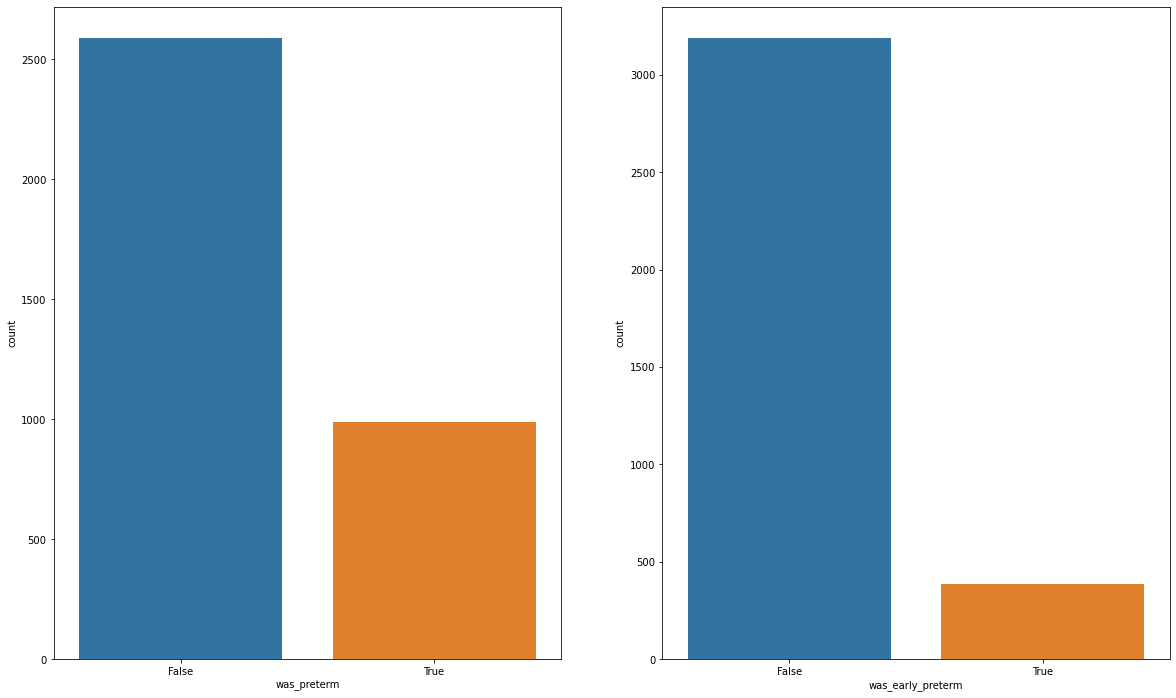

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 12))
count_preterm = plt.subplot(121)
sns.countplot(data=metadata, x="was_preterm")
count_preterm = plt.subplot(122)
sns.countplot(data=metadata, x="was_early_preterm")
print(f"% of preterm {(sum(metadata['was_preterm']==True) / metadata.shape[0])}")
print(f"% of early preterm {(sum(metadata['was_early_preterm']==True) / metadata.shape[0])}")

As we can see, both problems are highly unbalanced and we must take it into account for the training of the models.

**Engineering characteristic**
We will use the phylo data and relative species abundance to generate two new variables "Kmediods_cluster" and "Kmediods_phylo", for such approach we will generate K-Mediods unsupervised model to generate 10 different clusters depending on the phylo and species data, such variables will be used in the generation of the preterm prediction model.

In [6]:
X_train_species=X_train[species.columns]
X_train_phylo=X_train[phylo.columns]
X_test_species=X_test[species.columns]
X_test_phylo=X_test[phylo.columns]

In [7]:
#!pip install scikit-learn-extra

In [8]:
from sklearn_extra.cluster import KMedoids
km = KMedoids(n_clusters=10, init='k-medoids++', random_state=0)
km.fit(X_train_species)

KMedoids(init='k-medoids++', n_clusters=10, random_state=0)

In [9]:
#Save Kmediods model
import pickle
filename = 'Models/kmediods_species.sav'
pickle.dump(km, open(filename, 'wb'))

In [10]:
X_train["Kmediods_cluster"]=km.labels_

<ipython-input-10-368e5c3ea0b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Kmediods_cluster"]=km.labels_


In [11]:
X_test["Kmediods_cluster"]=km.predict(X_test_species)

<ipython-input-11-2362ef49cf24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Kmediods_cluster"]=km.predict(X_test_species)


In [12]:
from sklearn_extra.cluster import KMedoids
km_phylo = KMedoids(n_clusters=10, init='k-medoids++', random_state=0)
km_phylo.fit(X_train_phylo)

KMedoids(init='k-medoids++', n_clusters=10, random_state=0)

In [13]:
#Save Kmediods model phylo
import pickle
filename = 'Models/kmediods_phylo.sav'
pickle.dump(km_phylo, open(filename, 'wb'))

In [14]:
X_train["Kmediods_phylo"]=km_phylo.labels_

<ipython-input-14-91e31e0264a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Kmediods_phylo"]=km_phylo.labels_


In [15]:
X_test["Kmediods_phylo"]=km_phylo.predict(X_test_phylo)

<ipython-input-15-1bc3d59678ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Kmediods_phylo"]=km_phylo.predict(X_test_phylo)


<AxesSubplot:xlabel='Kmediods_phylo', ylabel='count'>

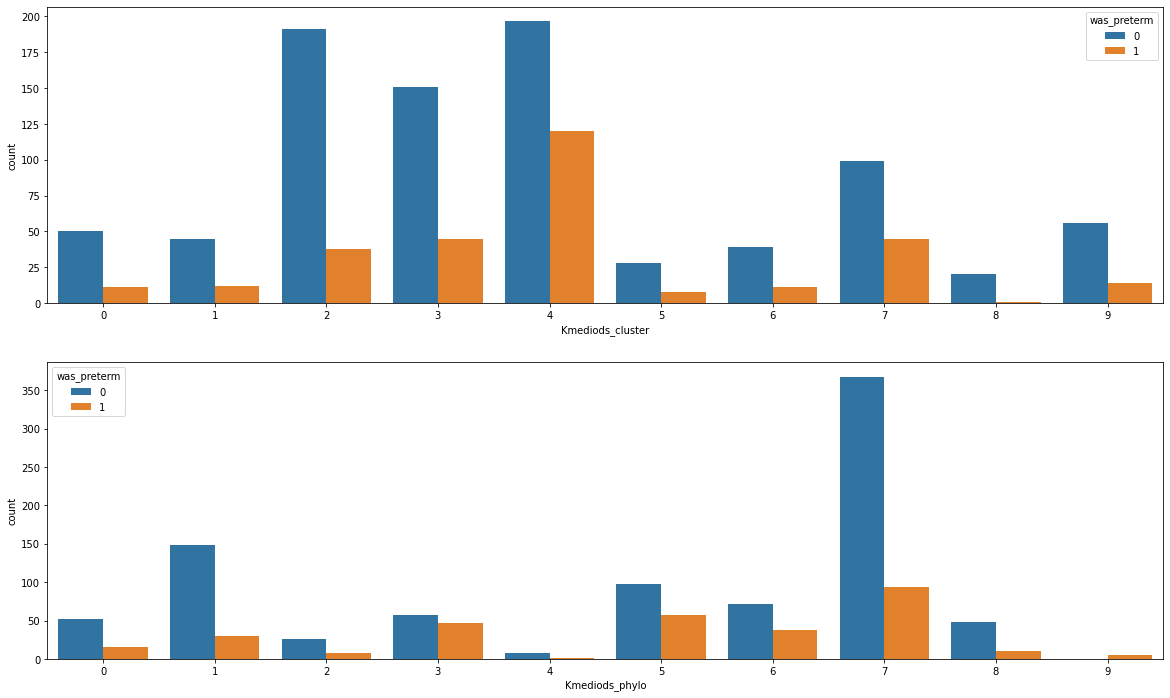

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 12))
bar_shannon = plt.subplot(211)
sns.countplot(data=pd.merge(X_test, y, left_index=True, right_index=True), x="Kmediods_cluster", hue="was_preterm")
bar_shannon = plt.subplot(212)
sns.countplot(data=pd.merge(X_test, y, left_index=True, right_index=True), x="Kmediods_phylo", hue="was_preterm")

We can see that some of the groups give information about the preterm birth, is some cases like group 2 in kmediods-cluster there is huge abundance of term samples. In the k-mediods_phylo group 3 the amount of term and preterm is almost the same, taking in count the unbalanced data that seems like a cluster were preterm birth is more common.

**Machine learning model**


In [17]:
dis_variables = X_train.select_dtypes(exclude=np.number).columns.to_list()+["Kmediods_cluster","Kmediods_phylo"]
num_variables = (
    X_train.select_dtypes(include=np.number).columns
    .drop(["Kmediods_cluster","Kmediods_phylo"]).to_list()
)

First of all the preprocessing pipeline, as we can see here, I will Standarize the numeric variables with a standard scaler and the discrete will be codified as a one hot encoder.

In [18]:
#Pre-processing pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

#Lista de tiempos que se usaran en el ensayo
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
                     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline([('scaler', StandardScaler())])
term_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_variables),
        ('cat', cat_transformer, dis_variables)])

And now the RandomForestRegressor tree, I tested houndred of models using Grid Search, this parameters are the best performing ones.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

term_pipe_RF = Pipeline([('prep', term_trans),
                 ('clas', RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',min_samples_leaf=1, 
                                                min_samples_split=2,n_estimators=1800))])
term_pipe_RF.fit(X_train, y_train["was_preterm"])
        

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ["'Geomonas' Khan et al. "
                                                   '2020',
                                                   'Abditibacterium',
                                                   'Abiotrophia defectiva',
                                                   'Absiella',
                                                   'Absiella dolichum',
                                                   'Abyssicoccus',
                                                   'Acetobacter',
                                                   'Acetobacter '
                                                   'cibinongensis/orientalis',
                                                   'Acetob

In [20]:
#Save RandomForest model phylo
import pickle
filename = 'Models/RandomForest_preterm.sav'
pickle.dump(term_pipe_RF, open(filename, 'wb'))

In [21]:
y_test["prediction_prob"]=term_pipe_RF.predict(X_test)

<ipython-input-21-be6d1d583180>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["prediction_prob"]=term_pipe_RF.predict(X_test)


In [22]:
from sklearn import metrics
metrics.roc_auc_score(y_test["was_preterm"], term_pipe_RF.predict(X_test))

0.8450744816228759

Now we group the predictions by participant_id, obtaining the mean of the probabilities when more than one sample was taken from the participant. I had tryed different aggregation methods and taking the minimal prediction when more than one sample is taken from a patient works better.

In [23]:
from sklearn import metrics
(
    metrics.roc_auc_score(y_test.groupby("participant_id").mean()["was_preterm"], 
                          y_test.groupby("participant_id").mean()["prediction_prob"])
)

0.8229199858382015

In [24]:
y_test.groupby("participant_id").mean()

,was_preterm,was_early_preterm,prediction_prob
participant_id,,,
A00004,0,0,0.201642
A00005,0,0,0.171463
A00006,0,0,0.227779
A00009,0,0,0.217410
A00010,0,0,0.271891
...,...,...,...
J00104,0,0,0.349356
J00108,0,0,0.309525
J00111,0,0,0.390183


<AxesSubplot:xlabel='prediction_prob', ylabel='Count'>

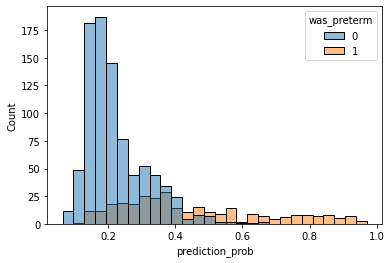

In [25]:
sns.histplot(y_test, x="prediction_prob", hue="was_preterm")

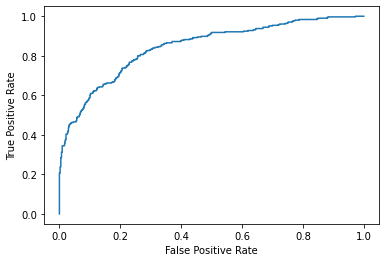

In [34]:
fpr, tpr, _ = metrics.roc_curve(y_test["was_preterm"],  y_test["prediction_prob"])
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Early preterm model**

This is an example of how grid search have been performed and which parameters were tested.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
parameters={'clas__bootstrap': [True, False],'clas__max_depth': [20],'clas__max_features': ['auto', 'sqrt'],'clas__min_samples_leaf': [1, 2, 4],'clas__min_samples_split': [2, 5, 10],'clas__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

term_pipe_RF = Pipeline([('prep', term_trans),
                 ('clas', RandomForestRegressor())])
GS = GridSearchCV(term_pipe_RF, param_grid=parameters, cv=5, verbose=10, scoring='roc_auc')
GS.fit(X_train, y_train["was_early_preterm"])
        
print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

RF = GS.best_estimator_

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

early_term_pipe_RF = Pipeline([('prep', term_trans),
                 ('clas', RandomForestRegressor(bootstrap=True, max_depth=50, max_features='sqrt',min_samples_leaf=2, 
                                                min_samples_split=5,n_estimators=800))])
early_term_pipe_RF.fit(X_train, y_train["was_early_preterm"])
        

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ["'Geomonas' Khan et al. "
                                                   '2020',
                                                   'Abditibacterium',
                                                   'Abiotrophia defectiva',
                                                   'Absiella',
                                                   'Absiella dolichum',
                                                   'Abyssicoccus',
                                                   'Acetobacter',
                                                   'Acetobacter '
                                                   'cibinongensis/orientalis',
                                                   'Acetob

In [27]:
#Save RandomForest model phylo
import pickle
filename = 'Models/RandomForest_early_preterm.sav'
pickle.dump(early_term_pipe_RF, open(filename, 'wb'))

In [28]:
from sklearn import metrics
metrics.roc_auc_score(y_test["was_early_preterm"], early_term_pipe_RF.predict(X_test))

0.8353488265633106

In [29]:
y_test["prediction_prob_early"]=early_term_pipe_RF.predict(X_test)

<ipython-input-29-a1784506c6d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["prediction_prob_early"]=early_term_pipe_RF.predict(X_test)


In [30]:
from sklearn import metrics
(
    metrics.roc_auc_score(y_test.groupby("participant_id").min()["was_early_preterm"], 
                          y_test.groupby("participant_id").min()["prediction_prob_early"])
)

0.8320602465535525

In [31]:
y_test.groupby("participant_id").mean()

,was_preterm,was_early_preterm,prediction_prob,prediction_prob_early
participant_id,,,,
A00004,0,0,0.201642,0.059332
A00005,0,0,0.171463,0.073693
A00006,0,0,0.227779,0.055344
A00009,0,0,0.217410,0.232053
A00010,0,0,0.271891,0.069048
...,...,...,...,...
J00104,0,0,0.349356,0.164489
J00108,0,0,0.309525,0.132744
J00111,0,0,0.390183,0.057294


<AxesSubplot:xlabel='prediction_prob_early', ylabel='Count'>

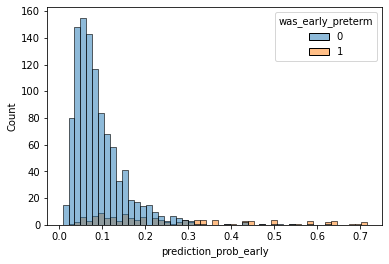

In [32]:
sns.histplot(y_test, x="prediction_prob_early", hue="was_early_preterm")

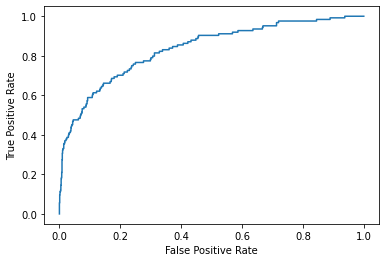

In [35]:
fpr, tpr, _ = metrics.roc_curve(y_test["was_early_preterm"],  y_test["prediction_prob_early"])
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Final models trained with all the data**

In [22]:
complete_df=(
    pd.merge(phylo_alpha_cst_species_metadata, genus, suffixes=(None, "_genus"), 
             left_index=True, right_index=True)
)
y=complete_df[["was_preterm", "was_early_preterm"]].astype("int")
y=pd.merge(y, complete_df["participant_id"], left_index=True, right_index=True)
complete_df.drop(["was_preterm", "was_term", "project", "participant_id", "delivery_wk", "was_early_preterm", "collect_wk"], axis=1, inplace=True)

In [23]:
X_train=complete_df.copy()

Train the kmediods models with all the data

In [24]:
X_train_species=X_train[species.columns]
X_train_phylo=X_train[phylo.columns]
X_test_species=X_test[species.columns]
X_test_phylo=X_test[phylo.columns]

In [25]:
from sklearn_extra.cluster import KMedoids
km = KMedoids(n_clusters=10, init='k-medoids++', random_state=0)
km.fit(X_train_species)

KMedoids(init='k-medoids++', n_clusters=10, random_state=0)

In [26]:
#Save Kmediods model
import pickle
filename = 'Models/kmediods_species_final.sav'
pickle.dump(km, open(filename, 'wb'))

In [27]:
X_train["Kmediods_cluster"]=km.labels_

In [28]:
from sklearn_extra.cluster import KMedoids
km_phylo = KMedoids(n_clusters=10, init='k-medoids++', random_state=0)
km_phylo.fit(X_train_phylo)

KMedoids(init='k-medoids++', n_clusters=10, random_state=0)

In [29]:
#Save Kmediods model phylo
import pickle
filename = 'Models/kmediods_phylo_final.sav'
pickle.dump(km_phylo, open(filename, 'wb'))

In [30]:
X_train["Kmediods_phylo"]=km_phylo.labels_

Train de models

In [31]:
dis_variables = X_train.select_dtypes(exclude=np.number).columns.to_list()+["Kmediods_cluster","Kmediods_phylo"]
num_variables = (
    X_train.select_dtypes(include=np.number).columns
    .drop(["Kmediods_cluster","Kmediods_phylo"]).to_list()
)

In [32]:
#Pre-processing pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

#Lista de tiempos que se usaran en el ensayo
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
                     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline([('scaler', StandardScaler())])
term_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_variables),
        ('cat', cat_transformer, dis_variables)])

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

term_pipe_RF = Pipeline([('prep', term_trans),
                 ('clas', RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',min_samples_leaf=1, 
                                                min_samples_split=2,n_estimators=1800))])
term_pipe_RF.fit(X_train, y["was_preterm"])
        

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ["'Geomonas' Khan et al. "
                                                   '2020',
                                                   'Abditibacterium',
                                                   'Abiotrophia defectiva',
                                                   'Absiella',
                                                   'Absiella dolichum',
                                                   'Abyssicoccus',
                                                   'Acetobacter',
                                                   'Acetobacter '
                                                   'cibinongensis/orientalis',
                                                   'Acetob

In [34]:
#Save RandomForest model phylo
import pickle
filename = 'Models/RandomForest_preterm_final.sav'
pickle.dump(term_pipe_RF, open(filename, 'wb'))

**Early preterm model**

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

early_term_pipe_RF = Pipeline([('prep', term_trans),
                 ('clas', RandomForestRegressor(bootstrap=True, max_depth=50, max_features='sqrt',min_samples_leaf=2, 
                                                min_samples_split=5,n_estimators=800))])
early_term_pipe_RF.fit(X_train, y["was_early_preterm"])
        

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ["'Geomonas' Khan et al. "
                                                   '2020',
                                                   'Abditibacterium',
                                                   'Abiotrophia defectiva',
                                                   'Absiella',
                                                   'Absiella dolichum',
                                                   'Abyssicoccus',
                                                   'Acetobacter',
                                                   'Acetobacter '
                                                   'cibinongensis/orientalis',
                                                   'Acetob

In [36]:
#Save RandomForest model phylo
import pickle
filename = 'Models/RandomForest_early_preterm_final.sav'
pickle.dump(early_term_pipe_RF, open(filename, 'wb'))